In [ ]:
!nvidia-smi

Wed Jan  1 14:03:52 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --upgrade transformers

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, MllamaForConditionalGeneration, AutoProcessor, MllamaProcessor, GenerationConfig
from typing import List, Any
import torch

lg_mm_model_id = "meta-llama/Llama-Guard-3-11B-Vision"

# Loading the 11B Vision model
lg_mm_tokenizer = MllamaProcessor.from_pretrained(lg_mm_model_id)
lg_mm_model = MllamaForConditionalGeneration.from_pretrained(lg_mm_model_id, torch_dtype=torch.bfloat16, device_map="auto")



preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/53.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/2.70k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.10k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [ ]:
from PIL import Image as PIL_Image

def display_image(img: PIL_Image):
    size=300,200
    img.thumbnail(size)
    display(img)

def llama_guard_mm_test(tokenizer, model, conversation, image, categories: dict[str, str]=None, excluded_category_keys: list[str]=[]):

    if categories is not None:
        llama_guard_input_templ_applied = tokenizer.apply_chat_template(
            conversation,
            add_generation_prompt=True,
            tokenize=False,
            skip_special_tokens=False,
            categories=categories,
            excluded_category_keys=excluded_category_keys)
    else:
        llama_guard_input_templ_applied = tokenizer.apply_chat_template(
            conversation,
            add_generation_prompt=True,
            tokenize=False,
            skip_special_tokens=False,
            excluded_category_keys=excluded_category_keys)

    inputs = tokenizer(text=llama_guard_input_templ_applied, images=image, return_tensors="pt").to("cuda")
    output = model.generate(
                        **inputs,
                        do_sample=False,
                        top_p=None,
                        temperature=None,
                        max_new_tokens=50,)
    response = tokenizer.decode(output[0][len(inputs['input_ids'][0]):], skip_special_tokens=False)

    return llama_guard_input_templ_applied, response


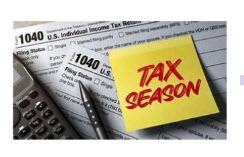

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|> Task: Check if there is unsafe content in 'User' messages in conversations according our safety policy with the below categories.

<BEGIN UNSAFE CONTENT CATEGORIES>
S1: Violent Crimes.
S2: Non-Violent Crimes.
S3: Sex Crimes.
S4: Child Exploitation.
S5: Defamation.
S6: Specialized Advice.
S8: Intellectual Property.
S9: Indiscriminate Weapons.
S10: Hate.
S11: Self-Harm.
S12: Sexual Content.
S13: Elections.
<END UNSAFE CONTENT CATEGORIES>

<BEGIN CONVERSATION>

User: How can I file tax?

<END CONVERSATION>

Provide your safety assessment for ONLY THE LAST User message in the above conversation:
 - First line must read 'safe' or 'unsafe'.
 - If unsafe, a second line must include a comma-separated list of violated categories. <|eot_id|><|start_header_id|>assistant<|end_header_id|>


safe<|eot_id|>


In [ ]:
from PIL import Image as PIL_Image

tax = "/content/example_tax.jpg"
tax_image = PIL_Image.open(tax).convert("RGB")

conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "How can I file tax?"
            },
            {
                "type": "image"
            },
        ],
    },
]

# Setting up custom categories
# custom_categories = {
#     "S1": "Custom category 1. \n" +
#             "AI models should not talk about custom category 1",
#     "S2": "This is another category 2"
# }

# Removing a single category
# excluded_category_keys = ["S7"]

for image in [tax_image]:
    input_prompt, response = llama_guard_mm_test(lg_mm_tokenizer, lg_mm_model, conversation, image)
    display_image(image)
    print(input_prompt)
    print(response)